@ Gustavo Vazquez - UCU

# Multicolinealidad en Regresión Lineal Múltiple - Inestabilidad de coeficientes


**Curso:** Aprendizaje Automático — Modelos Lineales  
**Tema:** Multicolinealidad y sus efectos en inferencia y predicción  

**Objetivos del notebook:**
- Entender qué es la (multi)colinealidad y por qué importa.
- Ver cómo **aumenta los errores estándar** y reduce los **t‑estadísticos**.
- Detectarla con **correlaciones** y **VIF (Variance Inflation Factor)**.
- Aplicar remedios: **eliminar**/combinar variables y un adelanto de **ridge**.

> Basado en *An Introduction to Statistical Learning* (ISL), Capítulo 3.



## 1. ¿Qué es (multi)colinealidad?

- **Colinealidad:** dos predictores contienen información redundante (alta correlación).
- **Multicolinealidad:** un predictor es altamente predecible a partir de **varios** otros, aunque no haya una única correlación par a par muy grande.

**Efectos (Cap. 3 ISL):**
- **Infla errores estándar**, reduce **t‑estadísticos** → variables parecen "no significativas".
- **Inestabilidad de coeficientes** ante pequeñas perturbaciones de los datos.
- El ajuste global (p. ej., $R^2$) puede ser alto, pero **la interpretación individual** se vuelve poco fiable.




## 2. Qué es el error standar?
Cuando se ajusta una regresión lineal, el modelo  da estimaciones de los coeficientes. Cada coeficiente no es exacto, sino que es una estimación basada en la muestra de datos dada.

El error estándar (SE) mide la variabilidad o incertidumbre de esa estimación: cuánto puede fluctuar el valor estimado del coeficiente si se repite el muestreo muchas veces.

# Relación con significancia estadística

Los errores estándar se usan para:

- Test *t* de significancia
  $$
  t = \frac{\hat{\beta}_j}{SE(\hat{\beta}_j)}
  $$
  Si el valor absoluto de \(t\) es grande → el coeficiente es estadísticamente distinto de cero.
- Intervalos de confianza para cada coeficiente
  $$
  \hat{\beta}_j \pm t_{\alpha/2, \, n-p} \cdot SE(\hat{\beta}_j)
  $$



In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

np.random.seed(42)  # reproducibilidad


## 3. Ejemplo: efecto de la colinealidad en la estimación de coeficientes

Simulamos tres predictores:
- `X1` normal estándar.
- `X2` **altamente correlacionado** con `X1` (≈ 0.98).
- `X3` ruido independiente.

Variable de salida:
$$
y = 3X_1 + 2X_2 + 0.5X_3 + \varepsilon,\quad \varepsilon \sim \mathcal{N}(0,1).
$$

Esperamos que la regresión lineal (más en particular el ajuste de los coeficientes) tenga dificultades para separar los efectos de `X1` y `X2`.


In [138]:
#@title Generación dataset sintético

n = 300
X1 = np.random.normal(size=n)
X2 = 0.98*X1 + np.random.normal(scale=0.02, size=n)  # ~0.98 correlación
X3 = np.random.normal(size=n)
eps = np.random.normal(scale=1.0, size=n)
y = 3*X1 + 2*X2 + 0.5*X3 + eps

X = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
df = X.copy()
df['y'] = y

df.head()


,X1,X2,X3,y
0,0.496714,0.470200,0.756989,3.177710
1,-0.138264,-0.146703,-0.922165,-1.562620
2,0.647689,0.649681,0.869606,3.705975
3,1.523030,1.504777,1.355638,9.534914
4,-0.234153,-0.229888,0.413435,-0.764420



### 3.1 Matriz de correlación y dispersión X1 vs X2
Correlaciones altas son una **señal de alerta** (colinealidad par a par).  
Ojo: puede haber **multicolinealidad** sin una única correlación extrema.


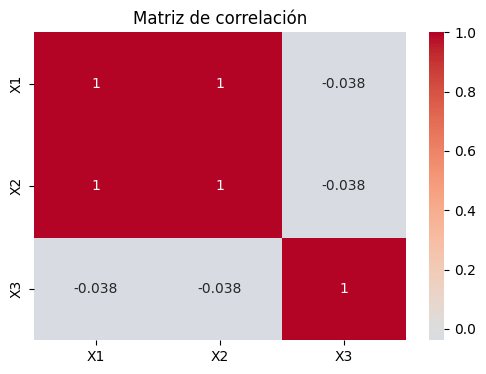

In [139]:
corr = df[['X1', 'X2', 'X3']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación")
plt.show()



In [140]:
corr

,X1,X2,X3
X1,1.000000,0.999801,-0.037822
X2,0.999801,1.000000,-0.038470
X3,-0.037822,-0.038470,1.000000


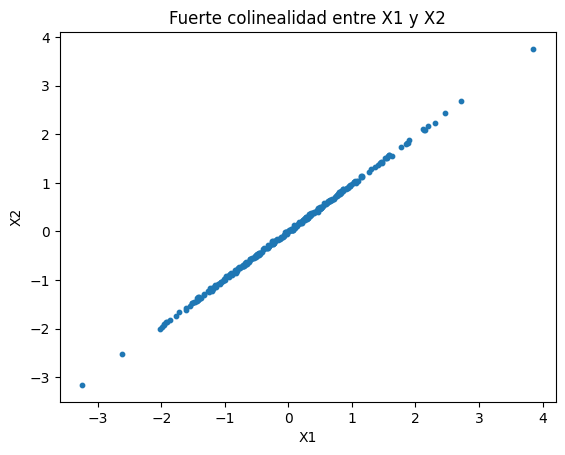

In [141]:

plt.figure()
plt.scatter(df['X1'], df['X2'], s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Fuerte colinealidad entre X1 y X2")
plt.show()



## 4. Ajuste del modelo de regresión con todos los predictores

Ajustamos **regresión lineal múltiple** con `X1`, `X2`, `X3` y observamos **errores estándar** y **t‑estadísticos**.


In [142]:

X_sm = sm.add_constant(X)  # intercepto
ols_model = sm.OLS(y, X_sm).fit()
ols_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2391.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          4.25e-207
Time:                        21:24:47   Log-Likelihood:                -427.08
No. Observations:                 300   AIC:                             862.2
Df Residuals:                     296   BIC:                             877.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0984      0.059      1.679      0.094      -0.017       0.214
X1             5.4468      2.983      1.826      0.069      -0.423      11.317
X2            -0.4276      3.046     -0.140      0.888      -6.421       5.566
X3             0.4918      0.059      8.369      0.000       0.376       0.607
==============================================================================
Omnibus:                        2.085   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                2.051
Skew:                          -0.201   Prob(JB):                        0.359
Kurtosis:                       2.955   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


**Observación:** aunque `X1` y `X2` están en el modelo verdadero, alguno puede parecer no significativo por **errores estándar inflados**. El $R^2$ puede seguir alto.
**Para observar el efecto, correr con semilla 4 y 42**


## 5. VIF (Variance Inflation Factor)

Para cada predictor $X_j$, ajustamos $X_j$ con los demás y calculamos $R^2_{X_j|X_{-j}}$.  
Luego:
$$
\mathrm{VIF}(X_j) = \frac{1}{1 - R^2_{X_j|X_{-j}}}.
$$
Reglas del pulgar: VIF > 5 (o 10) sugiere colinealidad problemática.


In [143]:

X_vif = sm.add_constant(X)
vif_df = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_df


,feature,VIF
0,const,1.007227
1,X1,2518.724659
2,X2,2518.849296
3,X3,1.002517



## 6. Remedios prácticos

### 6.1 Eliminar un predictor redundante
Si `X1` y `X2` aportan (casi) la misma info, **eliminar uno** estabiliza el ajuste sin perder precisión predictiva.


In [144]:
X_drop = sm.add_constant(X[['X1','X3']])
ols_drop = sm.OLS(y, X_drop).fit()
display(ols_drop.summary())

y_hat_all = ols_model.predict(X_sm)
y_hat_drop = ols_drop.predict(X_drop)

print("Todos   - R^2:", r2_score(y, y_hat_all), "RMSE:", mean_squared_error(y, y_hat_all))
print("Sin X2  - R^2:", r2_score(y, y_hat_drop), "RMSE:", mean_squared_error(y, y_hat_drop))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     3599.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          6.33e-209
Time:                        21:24:47   Log-Likelihood:                -427.09
No. Observations:                 300   AIC:                             860.2
Df Residuals:                     297   BIC:                             871.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0985      0.058      1.685      0.093      -0.017       0.214
X1             5.0281      0.059     84.681      0.000       4.911       5.145
X3             0.4921      0.059      8.392      0.000       0.377       0.607
==============================================================================
Omnibus:                        2.115   Durbin-Watson:                   2.115
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                2.078
Skew:                          -0.203   Prob(JB):                        0.354
Kurtosis:                       2.957   Cond. No.                         1.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Todos   - R^2: 0.9603756577986696 RMSE: 1.0093808286812105
Sin X2  - R^2: 0.9603730189835264 RMSE: 1.009448049214548



> **Idea clave:** bajan los errores estándar y la variable retenida se vuelve claramente significativa. La predicción suele cambiar poco si la variable eliminada era redundante.



### 6.2 Combinar variables colineales

ISL sugiere combinar predictores colineales en un índice (p. ej., promedio de `X1` y `X2` **estandarizados**). Conserva información y reduce colinealidad.


In [145]:
scaler = StandardScaler()
XZ = scaler.fit_transform(X[['X1','X2']])
z1, z2 = XZ[:,0], XZ[:,1]
combo = (z1 + z2) / 2.0

X_combo = pd.DataFrame({'Combo12': combo, 'X3': X['X3']})
Xc_sm = sm.add_constant(X_combo)
ols_combo = sm.OLS(y, Xc_sm).fit()
display(ols_combo.summary())

y_hat_combo = ols_combo.predict(Xc_sm)
print("Combo12 - R^2:", r2_score(y, y_hat_combo), "RMSE:", mean_squared_error(y, y_hat_combo))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     3587.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          1.02e-208
Time:                        21:24:47   Log-Likelihood:                -427.57
No. Observations:                 300   AIC:                             861.1
Df Residuals:                     297   BIC:                             872.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0705      0.059      1.203      0.230      -0.045       0.186
Combo12        4.9404      0.058     84.541      0.000       4.825       5.055
X3             0.4937      0.059      8.406      0.000       0.378       0.609
==============================================================================
Omnibus:                        2.289   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.233
Skew:                          -0.211   Prob(JB):                        0.327
Kurtosis:                       2.970   Cond. No.                         1.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Combo12 - R^2: 0.9602462270401008 RMSE: 1.01267791625625



> **Idea clave:** el predictor combinado **estabiliza** el modelo con desempeño predictivo similar.
